# ДЗ 2

В этом задании нужно будет обучить архитектуру для задачи Image Classification. Вам нужно будет реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

In [4]:
import os
import numpy as np
from tqdm.notebook import tqdm
import random
import cv2
import albumentations as A
from torchmetrics import Accuracy
from IPython.display import clear_output
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import zipfile

# Необходимые функции

In [5]:
def get_dataset(path, classes, transform_resize):
    x, y = [], []
    for item in tqdm(range(len(classes))):
        path_class = path + '/n' + str(item)
        list_classes = os.listdir(path_class)
        for image_file in list_classes:
            image = cv2.imread(path_class + '/' + image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented_image = transform_resize(image=image)['image']
            x.append((torch.from_numpy(augmented_image).float()/255).permute(2, 0, 1))
            y.append(item)
    return x, y

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

def augment_batch(x, transform, batch_size=None):
    if batch_size == None:
        batch_size = x.shape[0]
    x_aug = torch.zeros(x.shape)
    for i in range(batch_size):
        x_aug[i] = torch.from_numpy(transform(image=np.array(x[i].permute(1, 2, 0)))['image']).permute(2, 0, 1)
    return x_aug

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [51]:
def time_of_function(func):
    def wrapper(*args, **kwargs):
        """Подсчёт времени выполнения одной эпохи"""

        import time

        start = time.time()
        train_loss, val_loss = func(*args)
        end = time.time()
        delta = end - start
        count_minutes = int(delta / 60)
        count_seconds = int(delta - count_minutes*60)
        return train_loss, val_loss, count_minutes, count_seconds
    return wrapper

def logger(log: str, path: str):
    """Функция для логгирования"""
    with open(path + "/logs.txt", "a+") as logs:
        logs.write(log + "\n")

def plot_train(history: list, train_history: list=None, val_history: list=None):
    """Функция для отрисовки графиков лосса"""
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(13, 6))
    clear_output(True)
    ax1.plot(np.arange(1, len(history)+1), history, label='Train loss')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel("Loss")
    ax1.set_title('Train loss')
    if train_history is not None:
        ax2.plot(np.arange(1, len(train_history)+1), train_history, label='Train history', color='orange')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel("Loss")
    if val_history is not None:
        ax2.plot(np.arange(1, len(val_history)+1), val_history, label='Valid history', color='green')
    plt.legend()
    plt.grid()
    plt.show()

def training(model, device, train_dataloader, optimizer, loss_func, clip, transform, train_history: list=None, val_history: list=None, isShow: bool=True):
    epoch_loss = 0
    history = []
    i = 0
    model.train()
    for x, y in train_dataloader:
        x = augment_batch(x, transform)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1) % 5 == 0 and isShow:
            plot_train(history, train_history, val_history)
        i += 1
    return epoch_loss / len(train_dataloader)

def evaluate(model, device, val_dataloader, loss_func):
    epoch_loss = 0
    history = []
    model.eval()
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            epoch_loss += loss.item()
            history.append(loss.cpu().data.numpy())
    return epoch_loss / len(val_dataloader)

@time_of_function
def run_step(model, device, train_dataloader, val_dataloader, optimizer, loss_func, clip, transform, train_history: list=None, val_history: list=None):
    train_loss = training(model, device, train_dataloader, optimizer, loss_func, clip, transform, train_history, val_history)
    val_loss = evaluate(model, device, val_dataloader, loss_func)
    return train_loss, val_loss

def run(CONFIG, model, device, train_dataloader, val_dataloader, optimizer, loss_func, transform):
    best_val_loss = float('inf')
    train_history, val_history = [], []
    for epoch in tqdm(range(CONFIG["num_epochs"])):

        #Отбрасываем в логи номер эпохи
        logger(f"Epoch: {epoch}", CONFIG["PATH_DIR"])
        print(f"Epoch: {epoch}")

        if epoch > 0:
            model.load_state_dict(torch.load(CONFIG["PATH"]))
        train_loss, val_loss, count_minutes, count_seconds = run_step(model, device, train_dataloader, val_dataloader, optimizer, loss_func, CONFIG["clip"], transform, train_history, val_history)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), CONFIG["PATH"])
        train_history.append(train_loss)
        val_history.append(val_loss)

        #отбрасываем в логи информацию о времени одной эпохи
        logger(f"The time of execution of epoch : {count_minutes}m {count_seconds}s", CONFIG["PATH_DIR"])
        print(f"The time of execution of epoch : {count_minutes}m {count_seconds}s")

        #отбрасываем в логи train_loss
        logger(f"Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}", CONFIG["PATH_DIR"])
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}")

        #отбрасываем в логи val_loss
        logger(f"Val. Loss: {val_loss:.3f} |  Val. PPL: {np.exp(val_loss):7.3f}", CONFIG["PATH_DIR"])
        print(f"Val. Loss: {val_loss:.3f} |  Val. PPL: {np.exp(val_loss):7.3f}")

    return train_history, val_history

def test_model(model, device, test_dataloader, CONFIG, num_classes):
    target, predictions = [], []
    model.load_state_dict(torch.load(CONFIG["PATH"]))
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            target.append(y)
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            predictions.append(pred.to('cpu'))
            
    predictions = torch.hstack(predictions)
    target = torch.hstack(target)

    #отбрасываем в логи confusion matrix
    confusion_mat = confusion_matrix(target, predictions)
    print("Confusion matrix:\n" + "\n" + str(confusion_mat) + "\n")
    logger("Confusion matrix:\n" + "\n" + str(confusion_mat) + "\n", CONFIG["PATH_METRIC"])

    #отбрасываем в логи classification report
    report = classification_report(target, predictions, target_names=monkey_classes)
    logger("Classification report:\n" + "\n" + report, CONFIG["PATH_METRIC"])
    print("Classification report:\n" + "\n" + report)

    #выведем accuracy отдельно
    acc = Accuracy(task="multiclass", num_classes=num_classes)
    accuracy = float(acc(torch.Tensor(predictions), torch.Tensor(target)))
    print(f"accuracy = {accuracy:.3f}")
    return accuracy

# Dataset

In [7]:
os.environ['KAGGLE_USERNAME'] = "oxygen1ium1"
os.environ['KAGGLE_KEY'] = "7f45c1d722ba4216e82a2cf4cfb231ec"
!kaggle datasets download -d slothkong/10-monkey-species

with zipfile.ZipFile('10-monkey-species.zip', 'r') as zip_ref:
    zip_ref.extractall()

100% 546M/547M [00:27<00:00, 23.3MB/s]
100% 547M/547M [00:27<00:00, 20.6MB/s]


# Data processing

In [8]:
PATH_train = './training/training'
PATH_val = './validation/validation'

monkey_classes = ['alouatta_palliata', 
                  'erythrocebus_patas', 
                  'cacajao_calvus', 
                  'macaca_fuscata', 
                  'cebuella_pygmea', 
                  'cebus_capucinus', 
                  'mico_argentatus', 
                  'saimiri_sciureus', 
                  'aotus_nigriceps', 
                  'trachypithecus_johnii']
                
transform_resize = A.Compose([A.Resize(height=512, width=512)])

x_train, y_train = get_dataset(PATH_train, monkey_classes, transform_resize)
x_val, y_val = get_dataset(PATH_val, monkey_classes, transform_resize)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
len(x_train), len(x_val)

(1098, 272)

## Augmentation

In [10]:
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.OpticalDistortion(p=0.3),
        A.Blur(blur_limit=3, p=0.1),
        A.Resize(height=512, width=512),
    ])
#random.seed(42) 

torch.Size([3, 512, 512])


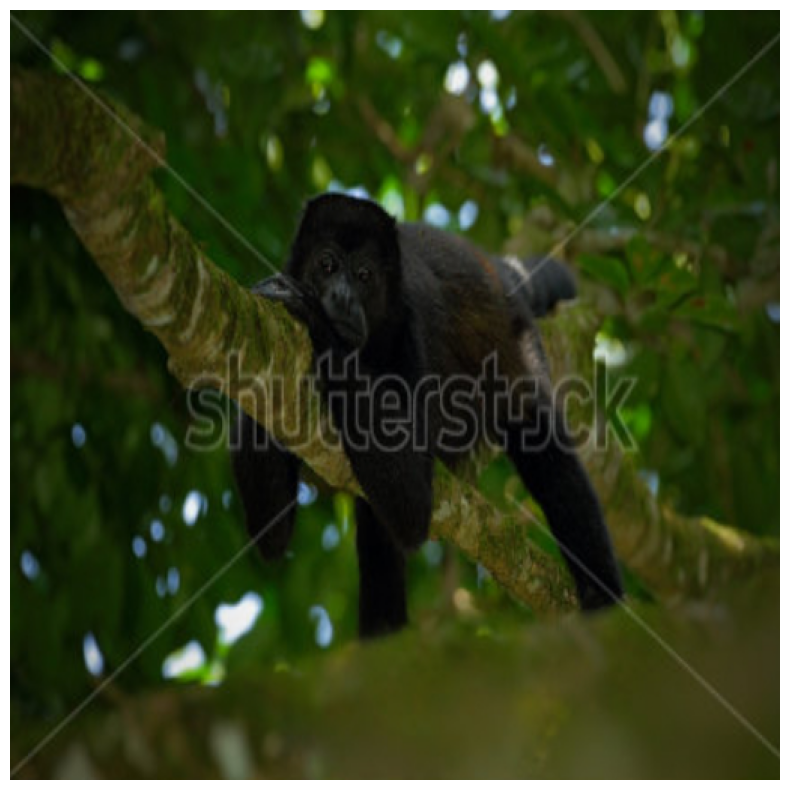

In [8]:
print(x_train[0].shape)
visualize(x_train[0].permute(1, 2, 0))

torch.Size([512, 512, 3])


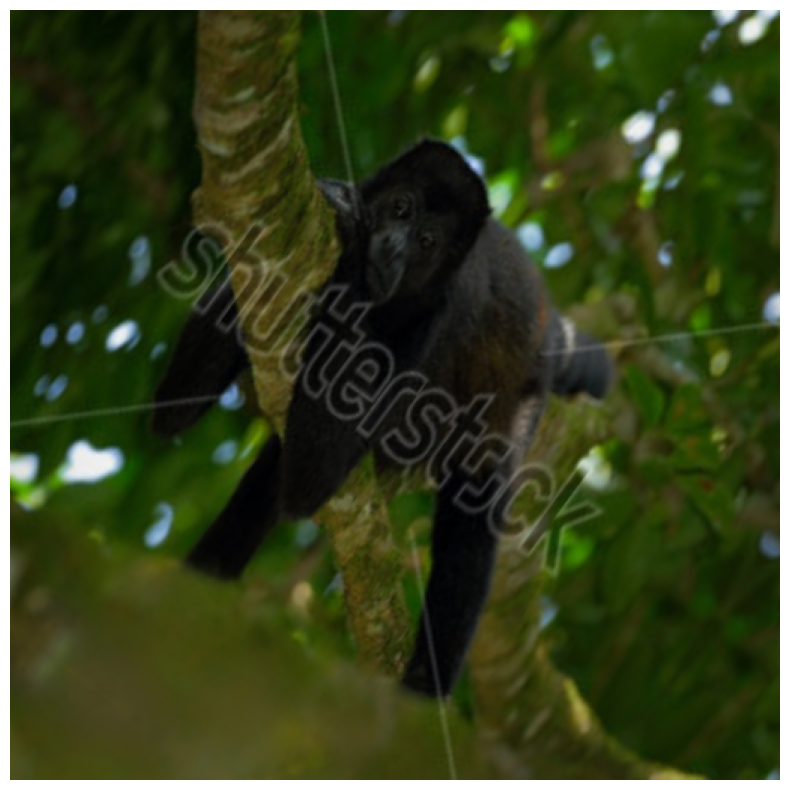

In [9]:
augmented_image = torch.from_numpy(transform(image=np.array(x_train[0].permute(1, 2, 0)))['image'])
print(augmented_image.shape)
visualize(augmented_image)

# Dataloader

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size=6, shuffle=True)
val_dataloader = DataLoader(list(zip(x_val, y_val)), batch_size=6, shuffle=False)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## VGG.

Реализуйте VGG16 from scratch. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (resnet, ViT???) - делайте, будет учтено.

Что будет оцениваться в задании:
* VGG16 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

In [13]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        ) 

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
model = VGG16(10)

if torch.cuda.is_available():
  device = torch.device("cuda") 
else:
  device = torch.device("cpu")
print("Device", device)

model = model.to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

Device cuda
The model has 134,309,962 trainable parameters


In [13]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x, transform)
    print(aug_x.shape)
    break

torch.Size([6, 3, 512, 512]) torch.Size([6])
torch.Size([6, 10])
torch.Size([6, 3, 512, 512])


In [14]:
del out #очищаем globals
del aug_x

# Train

In [15]:
VGG16_CONFIG = {
    "lr": 2e-5,
    "num_epochs": 30,
    "clip": 5,
    "PATH": 'drive/MyDrive/VGG16 steps/best_val_model.pt',
    "PATH_DIR": 'drive/MyDrive/VGG16 steps',
    "PATH_METRIC": 'drive/MyDrive/VGG16 steps/metrics',
    "isShow": True
}

optimizer = torch.optim.AdamW(model.parameters(), lr=VGG16_CONFIG["lr"])
loss_func = nn.CrossEntropyLoss()

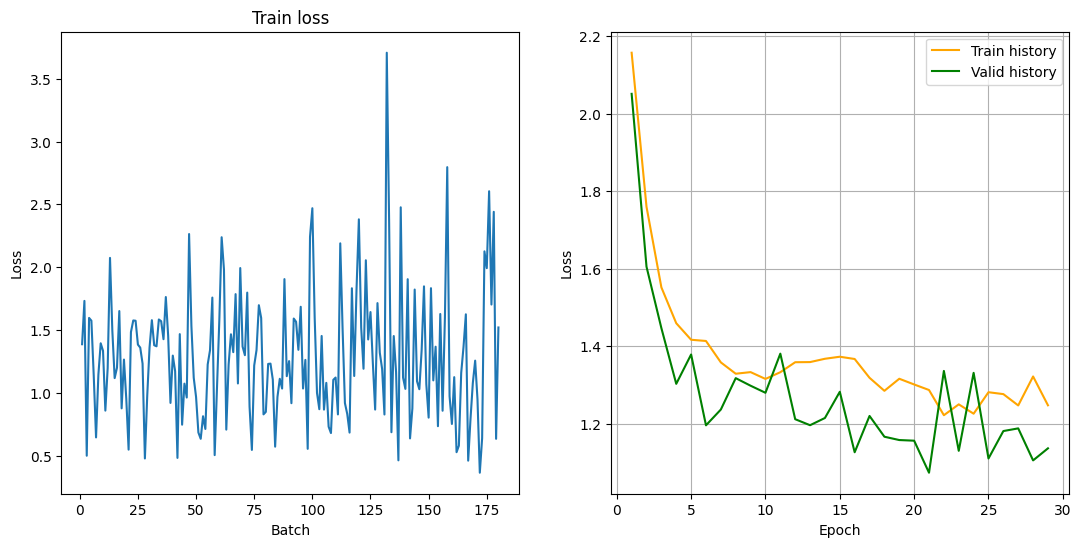

The time of execution of epoch : 2m 35s
Train Loss: 1.289 | Train PPL:   3.628
Val. Loss: 1.224 |  Val. PPL:   3.401


([2.157013860556597,
  1.7596829022214713,
  1.5519110905668123,
  1.4594006968326256,
  1.4167630050351712,
  1.413598471489109,
  1.3583606743747418,
  1.329158475815924,
  1.3332815653965122,
  1.315718864645463,
  1.3330564373503617,
  1.358815436969038,
  1.3591721580653895,
  1.3677189851719174,
  1.3729750142722834,
  1.3671507651362915,
  1.3186253003083943,
  1.2850707069120773,
  1.3161863855651168,
  1.3014427583074308,
  1.2871567978233587,
  1.2221298235687401,
  1.250178409404442,
  1.2260617656134516,
  1.2814372185149479,
  1.2765636377321565,
  1.2473291852435127,
  1.3220891371939352,
  1.2477191468405593,
  1.2887622106596421],
 [2.0509938649509265,
  1.6051565771517546,
  1.4468121775223508,
  1.3030798775346384,
  1.3787298649549484,
  1.196079539054114,
  1.2368281201823899,
  1.3177454700774474,
  1.298224182880443,
  1.2799924126137858,
  1.3808956150289462,
  1.2118873422884422,
  1.1963518650230507,
  1.2150018420880255,
  1.2825626416698745,
  1.1266204852448

In [18]:
run(VGG16_CONFIG, model, device, train_dataloader, val_dataloader, optimizer, loss_func, transform)

# Test and metrics

In [52]:
VGG16_accuracy = test_model(model, device, val_dataloader, VGG16_CONFIG, 10)

Confusion matrix:

[[10  0  0  0  0  4  0  2  0 10]
 [ 0 10  1  4  2  0  0  9  1  1]
 [ 0  0 23  1  0  1  1  0  1  0]
 [ 0  1  3 23  1  0  1  0  0  1]
 [ 0  1  0  0 17  1  0  7  0  0]
 [ 3  0  1  1  0 12  3  3  0  5]
 [ 0  3  0  1  1  0 16  5  0  0]
 [ 0  0  0  0  1  2  1 21  3  0]
 [ 0  0  1  1  5  0  0  9 11  0]
 [ 4  0  0  2  0  2  0  0  0 18]]

Classification report:

                       precision    recall  f1-score   support

    alouatta_palliata       0.59      0.38      0.47        26
   erythrocebus_patas       0.67      0.36      0.47        28
       cacajao_calvus       0.79      0.85      0.82        27
       macaca_fuscata       0.70      0.77      0.73        30
      cebuella_pygmea       0.63      0.65      0.64        26
      cebus_capucinus       0.55      0.43      0.48        28
      mico_argentatus       0.73      0.62      0.67        26
     saimiri_sciureus       0.38      0.75      0.50        28
      aotus_nigriceps       0.69      0.41      0.51     

# DenseNet201

In [21]:
from torchvision.models import densenet201

class DenseNet201(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet201, self).__init__()
        self.model = densenet201(pretrained=True)
        input_size = self.model.classifier.in_features
        self.model.classifier = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.model(x)
        return out

In [22]:
model2 = DenseNet201(10)

if torch.cuda.is_available():
  device = torch.device("cuda") 
else:
  device = torch.device("cpu")
print("Device", device)

model2 = model2.to(device)
print(f'The model has {count_parameters(model2):,} trainable parameters')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 285MB/s]


Device cuda
The model has 18,112,138 trainable parameters


In [18]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model2(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x, transform)
    print(aug_x.shape)
    break

torch.Size([6, 3, 512, 512]) torch.Size([6])
torch.Size([6, 10])
torch.Size([6, 3, 512, 512])


In [19]:
del out #очищаем globals
del aug_x

In [23]:
DenseNet201_CONFIG = {
    "lr": 3e-4,
    "num_epochs": 10,
    "clip": 5,
    "PATH": 'drive/MyDrive/DenseNet201/best_val_model.pt',
    "PATH_DIR": 'drive/MyDrive/DenseNet201',
    "PATH_METRIC": 'drive/MyDrive/DenseNet201/metrics',
    "isShow": True
}

optimizer = torch.optim.AdamW(model2.parameters(), lr=DenseNet201_CONFIG["lr"])
loss_func = nn.CrossEntropyLoss()

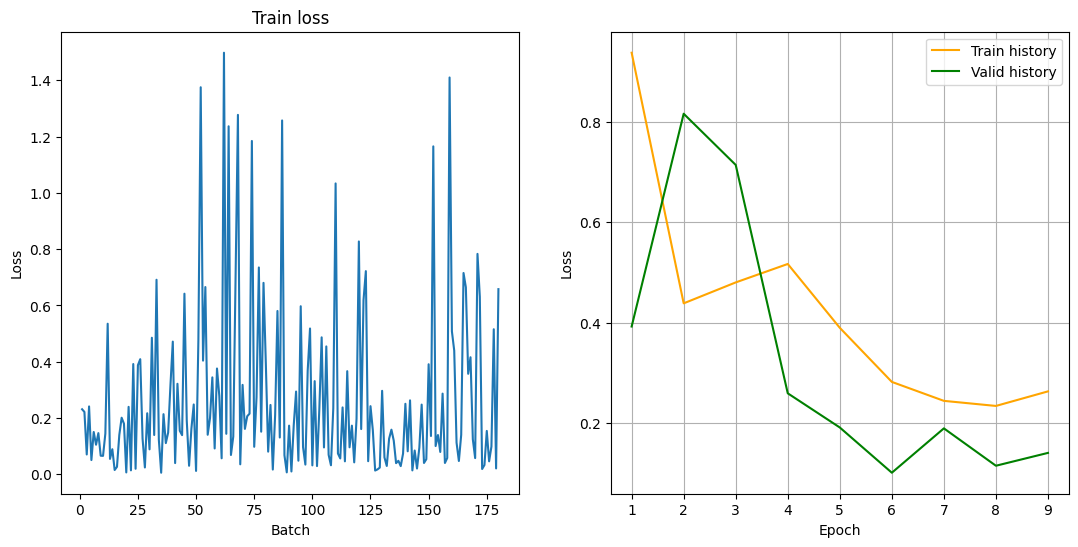

The time of execution of epoch : 1m 56s
Train Loss: 0.266 | Train PPL:   1.305
Val. Loss: 0.267 |  Val. PPL:   1.306


([0.9368808713278484,
  0.4385005791615593,
  0.480112779743033,
  0.5167909479939221,
  0.3898526565299008,
  0.2822575562485987,
  0.24456513124960857,
  0.23446649934109198,
  0.2634205150855654,
  0.266268243705294],
 [0.392383135298429,
  0.8155432695544416,
  0.7137410434128391,
  0.25957014344116347,
  0.19161709494485124,
  0.10165474924977626,
  0.1898574203267977,
  0.11554215855658581,
  0.14108939679768492,
  0.2669318198370646])

In [25]:
run(DenseNet201_CONFIG, model2, device, train_dataloader, val_dataloader, optimizer, loss_func, transform)

In [53]:
DenseNet201_accuracy = test_model(model2, device, val_dataloader, DenseNet201_CONFIG, 10)

Confusion matrix:

[[25  0  0  0  0  0  0  0  0  1]
 [ 0 26  0  0  0  0  0  0  0  2]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  0  0 27  1  1  0  0  0  1]
 [ 2  0  0  0 24  0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  1]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  1 26  0]
 [ 0  0  0  0  0  0  0  0  0 26]]

Classification report:

                       precision    recall  f1-score   support

    alouatta_palliata       0.93      0.96      0.94        26
   erythrocebus_patas       1.00      0.93      0.96        28
       cacajao_calvus       1.00      1.00      1.00        27
       macaca_fuscata       1.00      0.90      0.95        30
      cebuella_pygmea       0.96      0.92      0.94        26
      cebus_capucinus       0.97      1.00      0.98        28
      mico_argentatus       1.00      0.96      0.98        26
     saimiri_sciureus       0.97      1.00      0.98        28
      aotus_nigriceps       1.00      0.96      0.98     

# ResNeXt-101 64x4d

In [27]:
from torchvision.models import resnext101_64x4d

class ResNeXt_101(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNeXt_101, self).__init__()
        self.model = resnext101_64x4d(pretrained=True)
        input_size = self.model.fc.in_features
        self.model.classifier = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.model(x)
        return out

In [28]:
model3 = ResNeXt_101(10)

if torch.cuda.is_available():
  device = torch.device("cuda") 
else:
  device = torch.device("cpu")
print("Device", device)

model3 = model3.to(device)
print(f'The model has {count_parameters(model3):,} trainable parameters')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:03<00:00, 100MB/s]


Device cuda
The model has 83,475,762 trainable parameters


In [43]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model3(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x, transform)
    print(aug_x.shape)
    break

torch.Size([6, 3, 512, 512]) torch.Size([6])
torch.Size([6, 1000])
torch.Size([6, 3, 512, 512])


In [44]:
del out #очищаем globals
del aug_x

In [29]:
ResNeXt_101_CONFIG = {
    "lr": 3e-4,
    "num_epochs": 6,
    "clip": 5,
    "PATH": 'drive/MyDrive/ResNeXt_101/best_val_model.pt',
    "PATH_DIR": 'drive/MyDrive/ResNeXt_101',
    "PATH_METRIC": 'drive/MyDrive/ResNeXt_101/metrics',
    "isShow": True
}

optimizer = torch.optim.AdamW(model3.parameters(), lr=ResNeXt_101_CONFIG["lr"])
loss_func = nn.CrossEntropyLoss()

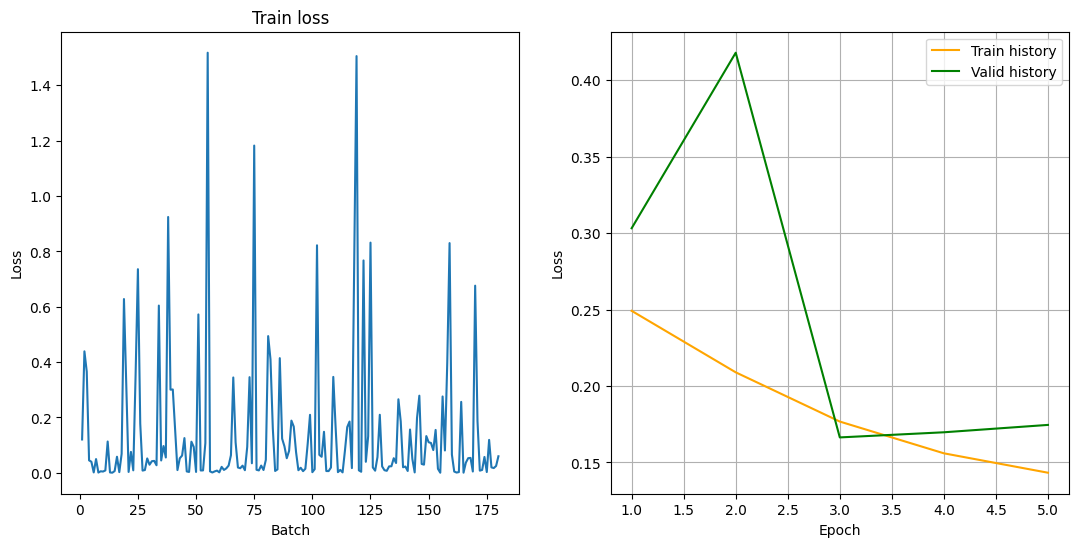

The time of execution of epoch : 4m 19s
Train Loss: 0.141 | Train PPL:   1.152
Val. Loss: 0.894 |  Val. PPL:   2.444


([0.24921693791676047,
  0.20898398971649476,
  0.17676956836081553,
  0.15600123823126727,
  0.14330370460636596,
  0.14127033531759317],
 [0.30324594924762927,
  0.418064355423469,
  0.16640580847935937,
  0.1697594277785633,
  0.1745821048066417,
  0.8935079623937306])

In [48]:
run(ResNeXt_101_CONFIG, model3, device, train_dataloader, val_dataloader, optimizer, loss_func, transform)

In [54]:
ResNeXt_101_accuracy = test_model(model3, device, val_dataloader, ResNeXt_101_CONFIG, 10)

Confusion matrix:

[[26  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  1  0  0  0  0  0  6]
 [ 0  0 25  1  0  1  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 1  0  0  0 25  0  0  0  0  0]
 [ 1  0  0  0  0 26  0  1  0  0]
 [ 0  1  0  0  0  0 23  2  0  0]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [ 1  0  0  0  0  0  0  0  0 25]]

Classification report:

                       precision    recall  f1-score   support

    alouatta_palliata       0.90      1.00      0.95        26
   erythrocebus_patas       0.95      0.75      0.84        28
       cacajao_calvus       1.00      0.93      0.96        27
       macaca_fuscata       0.94      1.00      0.97        30
      cebuella_pygmea       1.00      0.96      0.98        26
      cebus_capucinus       0.96      0.93      0.95        28
      mico_argentatus       1.00      0.88      0.94        26
     saimiri_sciureus       0.90      1.00      0.95        28
      aotus_nigriceps       1.00      1.00      1.00     

# Summary

Было обучени 3 модели:

*   VGG16, число обучаемых параметров 134,309,962, при этом accuracy = 0.59
*   DenseNet201, число обучаемых параметров 18,112,138, при этом accuracy = 0.96
*   ResNeXt-101 64x4d, число обучаемых параметров 83,475,762, при этом accuracy = 0.94



Метрики были выведены выше для каждой модели

Вывелем confusion_matrix и classification report для лучшей модели, то есть для DenseNet201:

In [55]:
with open(DenseNet201_CONFIG["PATH_METRIC"] + "/logs.txt", "r+") as f:
    for s in f:
        print(s[:-1])

Confusion matrix:

[[25  0  0  0  0  0  0  0  0  1]
 [ 0 26  0  0  0  0  0  0  0  2]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  0  0 27  1  1  0  0  0  1]
 [ 2  0  0  0 24  0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  1]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  1 26  0]
 [ 0  0  0  0  0  0  0  0  0 26]]

Classification report:

                       precision    recall  f1-score   support

    alouatta_palliata       0.93      0.96      0.94        26
   erythrocebus_patas       1.00      0.93      0.96        28
       cacajao_calvus       1.00      1.00      1.00        27
       macaca_fuscata       1.00      0.90      0.95        30
      cebuella_pygmea       0.96      0.92      0.94        26
      cebus_capucinus       0.97      1.00      0.98        28
      mico_argentatus       1.00      0.96      0.98        26
     saimiri_sciureus       0.97      1.00      0.98        28
      aotus_nigriceps       1.00      0.96      0.98     